# **Hands-on Session 2** (UKACM Autumn School)


This hands-on session comprises of two main sections:
1. Variational Inference
2. Gaussian Processes

To get started, please click 'File' --> select 'Save a copy in drive'.

## **Exercise 01: Variational Inference**

<hr>

Variational inference (VI), sometimes referred to as variational Bayes, is a technique that can speed up sampling by using an analytical *approximation* of the posterior.

The idea behind VI is to first posit a family of densities and then to find a member of that family which is the closest to the target density. The closeness is measured by **Kullback–Leibler (KL) divergence**.

### **Contents**

1.   Kullback-Leibler (KL) Divergence
2.   Evidence Lower Bound (ELBO)
3.   Reparameterisation
4.   Stochastic Optimisation

In [ ]:
# @title Import libraries
import numpy as np

import jax
import jax.numpy as jnp

from tensorflow_probability.substrates import jax as tfp

import optax

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")


### **Kullback-Leibler (KL) Divergence**

#### 1. **Entropy**

Entropy measures the uncertainty or variability, representing the expected information contained in a distribution.

The entropy $H[p(\mathbf{x})]$ of a distribution $p(\mathbf{x})$ is a non-negative measure of the amount of “uncertainty” in the distribution, and is defined as

\begin{align}
H[p(\mathbf{x})] = -\int{p(\mathbf{x})\log(p(\mathbf{x}))}\mathrm{d}\mathbf{x}\tag{1}
\end{align}

The integral is substituted by a sum for discrete variables.

#### 2. **Kullback-Leibler Divergence (Relative Entropy)**

Kullback-Leibler divergence is a measure from information theory that quantifies the difference between two probability distributions. It's often described as the "relative entropy" between two distributions, and is used to determine how one probability distribution diverges from another distribution.

Given two distributions $p(\mathbf{x})$ (the true distribution) and $q(\mathbf{x})$ (the approximating distribution), the KL divergence of $p$ from $q$ is defined as:

\begin{align}
\text{KL}(q \parallel p) &= \int q(\mathbf{x}) \log\left(\frac{q(\mathbf{x})}{p(\mathbf{x})}\right) \mathrm{d}\mathbf{x} \\\tag{2}
&= \mathbb{E}_{q} \left[\log \frac{q(\mathbf{x} )}{p(\mathbf{x} )}\right]\\
&= \mathbb{E}_{q} \left[\log q(\mathbf{x} ) - \log p(\mathbf{x} )\right]\\
&= \mathbb{E}_{q} \left[-\log p(\mathbf{x} )\right] - \mathbb{E}_{q} \left[-\log q(\mathbf{x} )\right]\\
\end{align}

<!-- Or, for discrete distributions:

\begin{align}
\text{KL}(q \parallel p) = \sum q(\mathbf{x}) \log\left(\frac{q(\mathbf{x})}{p(\mathbf{x})}\right)\tag{3}
\end{align} -->

##### Key Points:
- Asymmetry: KL divergence is not symmetric $\text{KL}(p \parallel q) \neq \text{KL}(q \parallel p) $.
- Non-negative: The value of KL divergence is always non-negative. It equals 0 only if $p$ and $q$ are identical.
- Interpretation: KL divergence measures how much information is lost when $q$ is used to approximate $p$.

#### 3. **Example**

##### Preparation



In [ ]:
# Initialise the module in tensorflow_probability
dist = tfp.distributions

In [ ]:
# Set the random seed
key = jax.random.PRNGKey(1)

##### A distribution to be approximated

In [ ]:
# Initialise a non Gausssian distribution
p = dist.MixtureSameFamily(
    mixture_distribution=dist.Categorical(probs=jnp.array([0.5, 0.5])),
    components_distribution=dist.Normal(
        loc=jnp.array([-1.6, 0.1]), scale=jnp.array([0.6, 0.7])  # One for each component.
    ),
)

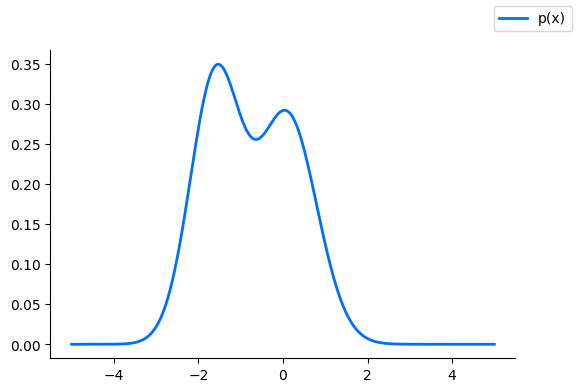

In [ ]:
x = jnp.linspace(-5.0, 5.0, 1000)
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, p.prob(x), label="p(x)", color="#006efe", lw=2)
fig.legend()
sns.despine()

##### KL divergence calculation

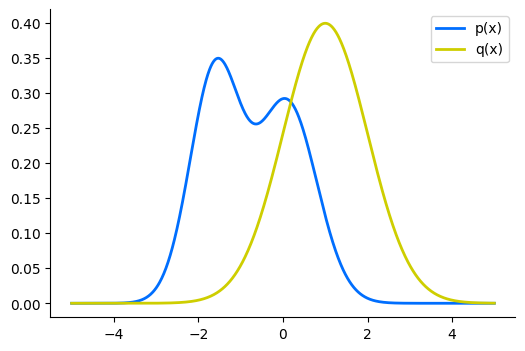

In [ ]:
# Choose an initial approximate distribution
q = dist.Normal(loc=1.0, scale=1.0)
plt.figure(figsize=(6, 4))
plt.plot(x, p.prob(x), label="p(x)", color="#006efe" ,lw=2)
plt.plot(x, q.prob(x), label="q(x)", color="#cece00", lw=2)
plt.legend()
sns.despine()


In [ ]:
# @title Try to compute KL divergence
def kl_via_sampling(
    p,
    q,
    n_samples=10000):
    """
    Computes the KL divergence of p from q using sampling.

    Args:
        p: The true probability distribution.
        q: The approximate probability distribution.
        n_samples: Number of samples to draw from the distribution (default: 1000).

    Returns:
        The estimated KL divergence.
    """

In [ ]:
# @title Compute KL divergence (answer)
def kl_via_sampling(
    p,
    q,
    n_samples=10000):
    """
    Computes the KL divergence of p from q using sampling.

    Args:
        p: The true probability distribution.
        q: The approximate probability distribution.
        n_samples: Number of samples to draw from the distribution (default: 1000).

    Returns:
        The estimated KL divergence.
    """
    # Set the random seed
    key = jax.random.PRNGKey(1)  # For reproducibility

    # Get samples from q
    sample_set = q.sample(
        seed=key,
        sample_shape=[n_samples]
    )

    # Compute KL divergence using the definition
    return jnp.mean(q.log_prob(sample_set) - p.log_prob(sample_set))

print('KL Divergence of {} from {} is {}'.format('p', 'q', kl_via_sampling(p, q)))

KL Divergence of p from q is 1.5856096744537354


### **Evidence Lower Bound (ELBO)**

In VI, we assume that any hyperparameters $\psi$ of the prior are fixed and focus solely on the posterior distribution of $\kappa$. The variational method approximates the true posterior $p(\kappa \mid y) $ by using a trial density $q(\kappa)$, which minimises the difference between a selected family of trial densities $D_q$ and the true posterior $p(\kappa \mid y) $. Such "difference" is quantified using the KL divergence. The VI objective is to solve:

\begin{align}
q^*(\kappa) = \underset{q(\kappa) \in D_q}{\arg \min} \, \text{KL}(q(\kappa) \parallel p(\kappa \mid y)).\tag{4}
\end{align}

Minimising the KL divergence can be interpreted as minimising the relative entropy between the two distributions.

By expanding the KL divergence, we get:

\begin{align}
\text{KL}\left(q(\kappa) \parallel p(\kappa \mid y)\right) &= \int q(\kappa) \log \frac{q(\kappa)}{p(\kappa \mid y)} \, d\kappa\\
&= \mathbb{E}_q\left[\log q(\kappa)\right] - \mathbb{E}_q\left[\log p(\kappa \mid y)\right]\\\tag{5}
&= \mathbb{E}_q\left[\log q(\kappa)\right] - \mathbb{E}_q\left[\log \frac{p(y, \kappa)}{p(y)}\right]\\
&= \mathbb{E}_q\left[\log q(\kappa)\right] - \mathbb{E}_q\left[\log p(y, \kappa)\right] + \log p(y).
\end{align}

The last term, the log-marginal likelihood $\log p(y)$, is typically intractable. Since we cannot compute the desired KL divergence directly, we instead optimize an alternative objective equivalent to this KL divergence up to a constant --- the *evidence lower bound* (ELBO):

\begin{align}
\text{ELBO}(q) \colon = \mathbb{E}_q[\log p(y, \kappa)] - \mathbb{E}_q[\log q(\kappa)].\tag{6}
\end{align}

This is essentially the negation of the first two terms in $\text{KL}\left(q(\kappa) \parallel p(\kappa \mid y)\right)$. We can rewrite the previous equation as:

\begin{align}
\log p(y) = \text{ELBO}(q) + \text{KL}\left(q(\kappa) \parallel p(\kappa \mid y)\right).\tag{7}
\end{align}

Since the KL divergence is non-negative, we have:

\begin{align}
\log p(y) \geq \text{ELBO}(q).\tag{8}
\end{align}

In other words, the log evidence $\log p(y)$, a fixed quantity for any given observations, is always greater than or equal to the ELBO. Therefore, by maximising the ELBO, we effectively minimise the KL divergence.

The ELBO can be rewritten as:

\begin{align}
\text{ELBO}(q) = \mathbb{E}_q[\log p(y \mid \kappa) + \log p(\kappa)] - \mathbb{E}_q[\log q(\kappa)]\tag{9}
\end{align}

which simplifies to:

\begin{align}
\text{ELBO}(q) = \mathbb{E}_q[\log p(y \mid \kappa)] - \text{KL}(q(\kappa) \parallel p(\kappa)).\tag{10}
\end{align}

Usually, $\text{KL}(q(\kappa) \parallel p(\kappa))$ can be evaluated analytically and $\mathbb{E}_q[\log p(y \mid \kappa)]$ is calculated via sampling.

Let’s assume we have two distributions:

1. $P(x) \sim \mathcal{N}(\mu_1, \sigma_1^2)$, with mean $\mu_1$ and variance $\sigma_1^2$.
2. $Q(x) \sim \mathcal{N}(\mu_2, \sigma_2^2)$, with mean $\mu_2$ and variance $\sigma_2^2$.

The KL divergence $\text{KL}(P \| Q)$ is given by:

\begin{align}
\text{KL}(P \| Q) = \log\left(\frac{\sigma_2}{\sigma_1}\right) + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2\sigma_2^2} - \frac{1}{2}\tag{11}
\end{align}


In [ ]:
# @title KL divergence between two Gaussian distributions
def kl_divergence_two_gaussians(mu1, sigma1, mu2, sigma2):
  """
  Calculates the KL divergence between two Gaussian distributions.

  Args:
    mu1: Mean of the first Gaussian distribution.
    sigma1: Standard deviation of the first Gaussian distribution.
    mu2: Mean of the second Gaussian distribution.
    sigma2: Standard deviation of the second Gaussian distribution.

  Returns:
    The KL divergence between the two Gaussian distributions.
  """
  kl_divergence = jnp.log(sigma2 / sigma1) + (sigma1 ** 2 + (mu1 - mu2) ** 2) / (2 * sigma2 ** 2) - 0.5
  return kl_divergence

# Example usage:
mu1 = 1.0
sigma1 = 2.0
mu2 = 3.0
sigma2 = 1.0

kl_div = kl_divergence_two_gaussians(mu1, sigma1, mu2, sigma2)
print(kl_div)


2.8068528


In [ ]:
# @title Expectation value of a Gaussian distribution $p(y|\kappa)$ under another Gaussian distribution $q(\kappa)$
def q_expectation_of_p(mu_q, sigma_q, mu_p, sigma_p, n_samples=10000):
  """
  Computes the expectation value of a Gaussian distribution p under another Gaussian distribution q.

  Args:
    mu_q: Mean of the approximating Gaussian distribution q.
    sigma_q: Standard deviation of the approximating Gaussian distribution q.
    mu_p: Mean of the Gaussian distribution p.
    sigma_p: Standard deviation of the Gaussian distribution p.
    n_samples: Number of samples to draw from the distribution (default: 1000).

  Returns:
    The expectation value of p under q.
  """
  # Set the random seed
  key = jax.random.PRNGKey(1)  # For reproducibility

  # Create the approximating normal distribution
  q = dist.Normal(loc=mu_q, scale=sigma_q)

  # Sample from the standard normal distribution
  std_normal = dist.Normal(loc=0.0, scale=1.0)
  sample_set = std_normal.sample(seed=key, sample_shape=[n_samples])

  # Update the sample set
  sample_set = mu_q + sigma_q * sample_set

  # Compute the expectation value of p under q
  p = dist.Normal(loc=mu_p, scale=sigma_p)
  return jnp.mean(p.log_prob(sample_set))


### **Reparameterisation**
<!-- To maximise the ELBO with a gradient-based optimiser, we need to evaluate itself and its gradients with respect to the parameters of $q(\kappa)$. Though the KL divergence term in the ELBO often has a closed-form solution, the term $ \mathbb{E}_q[\log p(y \mid \kappa)]$ does not. The reparameterisation trick enables gradient computation of quantities derived from samples of a probability distribution with respect to the parameters $\phi$ of that distribution. This is applicable to probability distributions where samples can be generated through a deterministic transformation, parameterised by $\phi$ , of other random variables. -->

<!-- Let $\epsilon$ represent a set of random variables. We assume that samples of $\kappa \sim q(\kappa; \phi)$ are generated by a deterministic function

\begin{align}
\kappa = t(\phi, \epsilon).
\end{align}

The KL divergence between the approximate distribution $q(\kappa)$ and the prior $p(\kappa)$ often has a closed-form solution, along with its gradients with respect to $\phi$. To estimate the gradients of the Monte Carlo approximation of the log-likelihood:

\begin{align}
\mathbb{E}_q[\log p(y \mid \kappa)] \approx \frac{1}{N_{\text{SVI}}} \sum_{i=1}^{N_{\text{SVI}}} \log p(y \mid \kappa^{(i)}),
\end{align}
where $\kappa^{(i)}$ is the $i$-th sample from $q(\kappa)$.

Then we apply the chain rule of differentiation to compute:

\begin{align}
\nabla_\phi \frac{1}{N_{\text{SVI}}} \sum_{i=1}^{N_{\text{SVI}}} \log p(y \mid \kappa^{(i)}) = \frac{1}{N_{\text{SVI}}} \sum_{i=1}^{N_{\text{SVI}}} \nabla_\kappa \log p(y \mid \kappa^{(i)}) \cdot \nabla_\phi t(\phi, \epsilon^{(i)}).
\end{align} -->

We assume both the prior and approximate posterior are Gaussian. Instead of the regular definition of $\kappa$
\begin{align}
\kappa \sim N(\mu, \sigma),\tag{12}
\end{align}
we define $\kappa$ as
\begin{align}
\kappa = \mu + \epsilon \sigma,\tag{13}
\end{align}
where $\epsilon \sim N(0, 1)$, $\mu$ and $\sigma$ are the parameters we want to optimise.

Through the above formulation, we remove the necessity of training the parameters for the randomness.

In [ ]:
# @title Compute KL divergence after reparameterisation
def kl_reparam(p,
               q_loc,
               q_scale,
               n_samples=10000):
    """
    Computes the KL divergence of p from q after reparameterising q.

    Args:
        p: The true probability distribution.
        q_loc: Mean of the approximate probability distribution.
        q_scale: Standard deviation of the approximate probability distribution.
        n_samples: Number of samples to draw from the distribution (default: 1000).

    Returns:
        The KL divergence after reparameterisation.
    """
    # Set the random seed
    key = jax.random.PRNGKey(1)  # For reproducibility

    # Create the reparameterised normal distribution
    q = dist.Normal(loc=q_loc, scale=q_scale)

    # Sample from the standard normal distribution
    std_normal = dist.Normal(loc=0.0, scale=1.0)
    sample_set = std_normal.sample(seed=key, sample_shape=[n_samples])

    # Update the sample set
    sample_set = q_loc + q_scale * sample_set

    # Use the definition of KL-divergence
    return jnp.mean(q.log_prob(sample_set) - p.log_prob(sample_set))


In [ ]:
# Compute the KL divergence after reparameterisation
klv_rep = kl_reparam(p, 0., 1.)
print('KL Divergence after reparameterisation of {} from {} is {}'.format('p', 'q', klv_rep))

KL Divergence after reparameterisation of p from q is 0.287878155708313


We can confirm that the KL-divergence we obtain via generating samples directly from $q$ or via generating samples from standard normal and then scaling are the same.

### **Stochastic Optimisation**

To maximise the ELBO, we use the ADAM algorithm. ADAM is a type of stochastic optimisation method commonly used for maximising non-convex functions. It works by estimating the gradient and performing gradient descent with an adaptive step size. ADAM is popular because it is stable across many problems and easy to use without much need for tuning.

In [ ]:
# @title ELBO
@jax.jit
def elbo(mu_p, sigma_p, params):
  """
  Defines the optimisation function as kl_divergence_two_gaussians minus q_expectation_of_p.

  Args:
    mu_q: Mean of the approximating Gaussian distribution q.
    sigma_q: Standard deviation of the approximating Gaussian distribution q.
    mu_p: Mean of the Gaussian distribution p.
    sigma_p: Standard deviation of the Gaussian distribution p.
    y: Mean of the prior distribution.
    sigma_eps: Standard deviation of the prior distribution.
    f: Constant value.
    kbar: Constant value.
    sigma_k: Constant value.

  Returns:
    The optimisation function value.
  """
  mu_q, sigma_q = params["loc"], params["scale"]
  mu_likeli = 1/mu_p
  sigma_likeli = 1/(mu_p)**2 * sigma_p
  kl_pq = kl_divergence_two_gaussians(mu_q, sigma_q, mu_p, sigma_p)
  expectation_value = q_expectation_of_p(mu_q, sigma_q, mu_likeli, sigma_likeli)
  return kl_pq - expectation_value


In [ ]:
# @title KL Divergence
@jax.jit
def kl_reparam(p,
               params,
               n_samples=100,
               key=jax.random.PRNGKey(1)):
    """
    Computes the KL divergence of p from q with args to be optimised.

    Args:
        p: The true probability distribution.
        params: A dictionary with "loc" and "scale" parameters for the q distribution.
        n_samples: Number of samples to draw from the distribution (default: 100).
        key: A JAX random key for reproducibility.

    Returns:
        The KL divergence after reparameterisation.
    """
    # Extract information from params
    q_loc, q_scale = params["loc"], params["scale"]

    # Create the reparameterised normal distribution
    q = dist.Normal(loc=q_loc, scale=q_scale)

    # Sample from the standard normal distribution
    std_normal = dist.Normal(loc=0.0, scale=1.0)
    sample_set = std_normal.sample(seed=key, sample_shape=[n_samples])

    # Update the sample set using reparameterisation
    sample_set = q_loc + q_scale * sample_set

    # Compute and return the KL divergence
    return jnp.mean(q.log_prob(sample_set) - p.log_prob(sample_set))

In [ ]:
# Create a function which takes the gradient of 'kl_reparam' w.r.t 'params'
grad_loss = jax.grad(kl_reparam, argnums = (1))

In [ ]:
# Initialise the parameters
params = {"loc": jnp.array([2.]), "scale": jnp.array([1.])}

In [ ]:
# Create and initialise the optimiser
optimiser = optax.adam(learning_rate:=0.01)
opt_state = optimiser.init(params)

In [ ]:
# Number of iterations to perform
num_iter = 600

# Initialise an empty array to store cost values across iterations
costs = np.empty(num_iter)

# Initialise a random number generator (RNG) key for JAX
key = jax.random.PRNGKey(1)

# Main optimisation loop
for i in range(num_iter):
    # Split the key to create a new subkey for reproducibility across operations
    key, subkey = jax.random.split(key)

    # Compute the current cost given 'p' and 'params'
    cost_val = kl_reparam(p, params, key=subkey)

    # Store the cost value in the 'costs' array
    costs[i] = cost_val

    # Compute the gradients of the loss function w.r.t. the parameters
    grads = grad_loss(p, params)

    # Update the model parameters using the optimiser
    updates, opt_state = optimiser.update(grads, opt_state)

    # Apply the updates to the parameters
    params = optax.apply_updates(params, updates)

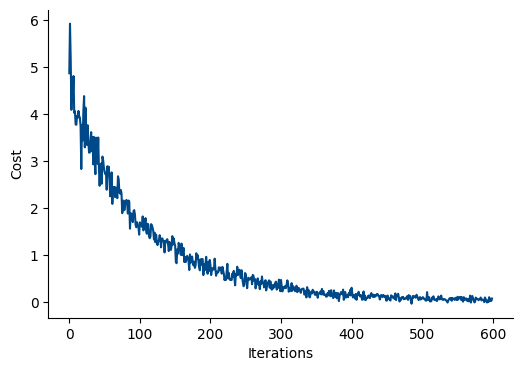

In [ ]:
# Plot the cost versus iteration figure to check convergence
plt.figure(figsize=(6, 4))
plt.plot(costs, color="#004989")
plt.xlabel("Iterations")
plt.ylabel("Cost")
sns.despine()

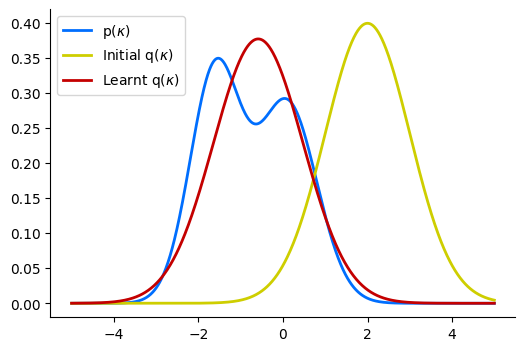

In [ ]:
# Instantiate the initial guess of the approximate distribution
q_init = dist.Normal(loc=2.0, scale=1.0)

# Instantiate the approximate distribution after optimisation
q_learnt = dist.Normal(loc=params["loc"], scale=params["scale"])

# Plot the results
x = jnp.linspace(-5.0, 5.0, 1000)
plt.figure(figsize=(6, 4))
plt.plot(x, p.prob(x), label="p($\kappa$)", lw=2, color='#006efe')
plt.plot(x, q_init.prob(x), label="Initial q($\kappa$)", lw=2, color='#cece00')
plt.plot(x, q_learnt.prob(x), label="Learnt q($\kappa$)", lw=2, color='#c40000')
plt.legend()
sns.despine()

## **Exercise 02: Gaussian Processes (GP)**

<hr>

### **Contents**

1.   **Introduction to Gaussian Processes**
- Inputs
- Prior
- Likelihood
- Posterior
- Prediction
2.   **Covariance Functions**
3.   **Gaussian Processes Regression**
- Prior
- Noise-free training data prediction
- Noisy training data prediction
- Impact of covariance and noise parameters
- Log marginal likelihood optimisation


In [ ]:
# @title Import libraries and define the plotting function
# import libraries
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from scipy.optimize import minimize


# Define csml colors as constants
CSML_COLOR = {
    'darkBlue': "#004989",
    'blue': '#006efe',
    'red': '#c40000',
    'black': '#000000',
    'yellow': '#cece00',
}

# Define the plot function
def plot_gp_result(ax, mean, covariance, x, num_samples=None, x_obs=None, y_obs=None):
    """
    Plots the Gaussian process results including the prior mean, confidence interval, samples, and observed data.

    Args:
        mean: Mean of the GP at each test point.
        covariance: Covariance matrix of the GP.
        x: Input points for plotting.
        num_samples: Number of samples to draw from the GP. Defaults to None.
        x_obs: Observed input points (training data). Defaults to None.
        y_obs: Observed output points (training data). Defaults to None.
    """
    np.random.seed(2)  # For reproducibility

    x = x.reshape(-1)
    mean = mean.reshape(-1)

    # 95% confidence interval calculation
    uncertainty = 1.96 * np.sqrt(np.diag(covariance))

    # Plot the mean with the confidence interval
    ax.fill_between(x, mean + uncertainty, mean - uncertainty, alpha=0.1, color=CSML_COLOR['darkBlue'])
    ax.plot(x, mean, label='Prior mean', color=CSML_COLOR['darkBlue'], lw=1.5)

    # Plot sample functions if requested
    if num_samples is not None:
        samples = np.random.multivariate_normal(mean, covariance, num_samples)
        colors = list(CSML_COLOR.values())
        for i, sample in enumerate(samples):
            ax.plot(x, sample, color=colors[(i+1) % len(colors)], lw=1, ls=':', label=f'Sample function {i+1}')

    # Plot observed data if provided
    if x_obs is not None and y_obs is not None:
        ax.plot(x_obs, y_obs, 'x', color=CSML_COLOR['red'], label='Training data')

    ax.legend()

### **Introduction to Gaussian Processes**

A Gaussian process defines a distribution over functions. Instead of providing a single function to fit a set of data, a GP provides a probability distribution over all possible functions that could fit the data.
It assumes that any finite set of function values has a joint multivariate normal (Gaussian) distribution.

1. **Inputs**:
   - Consider a dataset with inputs $\mathbf{x}_i \in \mathbb{R}^d$ for $i = 1, \dots, n $, where each input $\mathbf{x}_i$ is a vector in a $d$-dimensional space.
   - The inputs are stacked into a design matrix $\mathbf{X} \in \mathbb{R}^{n \times d}$, where each row corresponds to a $d$-dimensional input $\mathbf{x}_i $.

2. **Prior**:
   - A Gaussian process is defined as a distribution over functions $f(\mathbf{x})$ such that any finite collection of function values $\mathbf{f} = (f(\mathbf{x}_1), \dots, f(\mathbf{x}_n))^\top$ is jointly Gaussian:
     \begin{align}
     p(\mathbf{f} | \mathbf{X}) = \mathcal{N}(\mathbf{f} | \boldsymbol{\mu}, \mathbf{\Sigma})\tag{1}
     \end{align}

   - Here:
     - $\boldsymbol{\mu}$ is the mean vector: $\boldsymbol{\mu} = \left( m(\mathbf{x}_1), \dots, m(\mathbf{x}_n) \right)^\top$. Typically, for simplicity, $m(\mathbf{x}) = 0$.
     - $\mathbf{\Sigma}$ is the covariance matrix, where each element is computed using a covariance function: $\Sigma_{ij} = c(\mathbf{x}_i, \mathbf{x}_j)$.

3. **Likelihood**:
   - Given (noisy) observations $\mathbf{y} = (y_1, \dots, y_n)^\top$, assume that the observations are generated from the underlying function with Gaussian noise:

     \begin{align}
     y_i = f(\mathbf{x}_i) + \epsilon_i, \quad \epsilon_i \sim \mathcal{N}(0, \sigma_n^2)\tag{4}
     \end{align}

     The likelihood for the entire dataset is:

\begin{align}
p(\mathbf{y} | \mathbf{f}) = \mathcal{N}(\mathbf{y} | \mathbf{f}, \sigma_{n}^2 \mathbf{I}) \propto \exp\left( -\frac{1}{2} \sum_{i=1}^{n} \frac{(f_i - y_i)^2}{\sigma_{n}^2}
\right)\tag{5}
\end{align}

4. **Posterior**:
   - To obtain the posterior distribution of the function values given the observations, we use Bayes' rule:

     \begin{align}
     p(\mathbf{f} | \mathbf{X}, \mathbf{y}) \propto p(\mathbf{y} | \mathbf{f}) p(\mathbf{f} | \mathbf{X})\tag{6}
     \end{align}

   - The posterior distribution $p(\mathbf{f} | \mathbf{X}, \mathbf{y})$ is also Gaussian:

     \begin{align}
     p(\mathbf{f} | \mathbf{X}, \mathbf{y}) = \mathcal{N}(\mathbf{f} | \mathbf{m}_y, \mathbf{C}_y)\tag{7}
     \end{align}

     where the posterior mean $\mathbf{m}_y$ and covariance $\mathbf{C}_y$ are:

     \begin{align}
     \mathbf{m}_y(\mathbf{x}) = c(\mathbf{x}, \mathbf{X}) \left( c(\mathbf{X}, \mathbf{X}) + \sigma_n^2 \mathbf{I} \right)^{-1} \mathbf{y}
     \end{align}

     \begin{align}
     \mathbf{C}_y(\mathbf{x}, \mathbf{x}') = c(\mathbf{X}, \mathbf{X}') - c(\mathbf{x}, \mathbf{X}) \left( c(\mathbf{X}, \mathbf{X}) + \sigma_n^2 \mathbf{I} \right)^{-1} c(\mathbf{X}, \mathbf{x}')
     \end{align}

5. **Prediction**:
   - Given $n$ training data $\mathbf{X}$ and $\mathbf{y}$, and $n_*$ new test points $\mathbf{X}_*$, we want to predict the corresponding function value $f(\mathbf{X}_*)$.

   -  By definition of the GP, the joint distribution of observed data $\mathbf{y}$ and predictions $\mathbf{f}_*$ is

    \begin{align}
      \begin{pmatrix}\mathbf{y} \\ \mathbf{f}_*\end{pmatrix} \sim \mathcal{N}
      \left(\boldsymbol{0},
      \begin{pmatrix}\mathbf{C}_y & \mathbf{C}_* \\ \mathbf{C}_*^T & \mathbf{C}_{**}\end{pmatrix}
      \right)\tag{8}
    \end{align}
    
     where:
  $\mathbf{C}_y = c(\mathbf{X},\mathbf{X}) + \sigma_n^2\mathbf{I} = \mathbf{\Sigma} + \sigma_n^2\mathbf{I}$ is $n \times n$, $\mathbf{C}_* = c(\mathbf{X},\mathbf{X}_*)$ is $n \times n_*$ and $\mathbf{C}_{**} = c(\mathbf{X}_*,\mathbf{X}_*)$ is $n_* \times n_*$. $\sigma_n^2$ is the noise term in the diagonal of $\mathbf{C}_y$. It is set to zero if training targets are noise-free and to a value greater than zero if observations are noisy. The mean is set to $\boldsymbol{0}$ for notational simplicity.

   - The predictive distribution is:

      \begin{align}
      p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{X},\mathbf{y})
      &= \int{p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{f})p(\mathbf{f} \lvert \mathbf{X},\mathbf{y})}\ d\mathbf{f} \\
      &= \mathcal{N}(\mathbf{f}_* \lvert \boldsymbol{\mu}_*, \boldsymbol{\Sigma}_*)\tag{9}
      \end{align}

     Equation
  $(9)$ is the posterior predictive distribution which is also a Gaussian with mean $\boldsymbol{\mu}_*$ and $\boldsymbol{\Sigma}_*$.The sufficient statistics of the posterior predictive distribution, $\boldsymbol{\mu}_*$ and $\boldsymbol{\Sigma}_*$, can be computed with:

\begin{align}
\boldsymbol{\mu_*} &= \mathbf{C}_*^T \mathbf{C}_y^{-1} \mathbf{y}\tag{10} \\
\boldsymbol{\Sigma_*} &= \mathbf{C}_{**} - \mathbf{C}_*^T \mathbf{C}_y^{-1} \mathbf{C}_*\tag{11}
\end{align}

### **Covariance Functions**

There are many covariance functions that we can choose from (see [here](https://gaussianprocess.org/gpml/chapters/RW4.pdf)). In this example, we choose the squared exponential covariance:

$$
c(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2 \exp(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j))\tag{12}
$$

The length scale parameter $l$ controls the smoothness of the function and the signal variance $\sigma_f$ controls the vertical variation. For simplicity, we use the same length parameter $l$ for all input dimensions (isotropic).

In [ ]:
def sq_exp_covariance(x_i, x_j, sigma_f=1.0, l=1.0):
    """
    Calculate the squared exponential covariance between two sets of inputs, x_i and x_j.

    Args:
        x_i: Array of input points, shape (n_i, d).
        x_j: Array of input points, shape (n_j, d).
        l: Length scale parameter, default is 1.0.
        sigma_f: Signal variance parameter, default is 1.0.

    Returns:
        Covariance matrix of shape (n_i, n_j).
    """
    # Compute the squared Euclidean distances
    x_i_sq = np.sum(x_i**2, axis=1).reshape(-1, 1)  # shape (n_i, 1)
    x_j_sq = np.sum(x_j**2, axis=1)  # shape (n_j,)

    # Compute the dot product between the input arrays
    x_i_x_j = np.dot(x_i, x_j.T)  # shape (n_i, n_j)

    # Compute the squared distance matrix
    sq_dist = x_i_sq + x_j_sq - 2 * x_i_x_j  # shape (n_i, n_j)

    # Apply the squared exponential covariance function
    covariance = sigma_f**2 * np.exp(-sq_dist / (2 * l**2))  # shape (n_i, n_j)

    return covariance

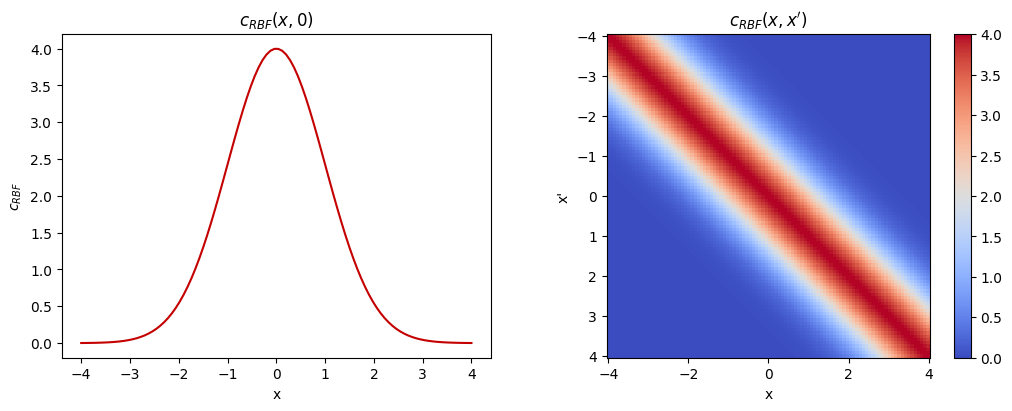

In [ ]:
# Define the sample space: 100 samples in the interval [-4, 4] and reshape into a column vector
x = np.linspace(-4., 4., 100).reshape(-1, 1)

# Set up the plotting environment
fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout="constrained")

# --- Figure 1: Plot c(x, 0) ---
ax = axs.flat[0]  # Left plot

# Slice the covariance function at x' = 0
cov_x_0 = sq_exp_covariance(x, np.array([[0.]]), sigma_f=2.0)  # c(x, 0)

# Customize the line color
line_color = CSML_COLOR['red']

# Plot the covariance function
ax.plot(x, cov_x_0, color=line_color)
ax.set_xlabel("x")
ax.set_ylabel("$c_{RBF}$")
ax.set_title("$c_{RBF}(x, 0)$")

# --- Figure 2: Plot c(x, x') ---
ax = axs.flat[1]  # Right plot

# Compute the full covariance function c(x, x')
cov_x_prime = sq_exp_covariance(x, x, sigma_f=2.0)

# Customize the colormap
colormap = 'coolwarm'

# Plot the covariance function as a colormap
im = ax.pcolor(x.T, x, cov_x_prime, cmap=cm.get_cmap(colormap))

# Adjust axis and color settings
ax.invert_yaxis()  # Invert y-axis
ax.set_aspect('equal')  # Ensure equal aspect ratio
ax.set_xlabel("x")
ax.set_ylabel("x'")
fig.colorbar(im, ax=ax)  # Add colorbar
ax.set_title("$c_{RBF}(x, x')$")

# Show the plots
plt.show()

### **Gaussian Process Regression**

#### **Prior**

Let's begin by defining a prior over functions with a zero mean and a covariance matrix based on covariance function parameters  $l=1$ and $\sigma_f=1$. To generate random functions from this Gaussian Process, we sample from the associated multivariate normal distribution. In the following example, three random functions are sampled and plotted, along with the zero mean and the 95% confidence interval (calculated from the diagonal elements of the covariance matrix).

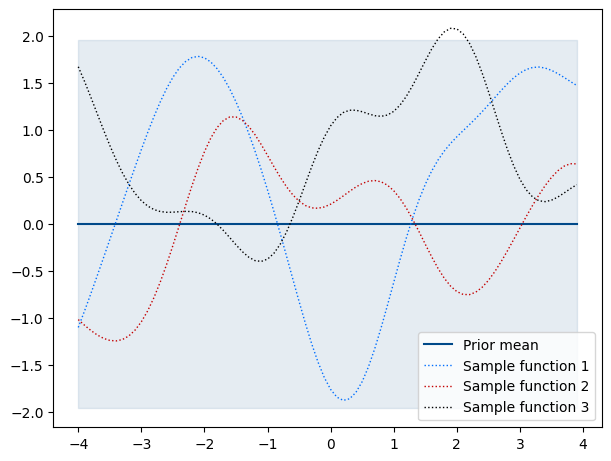

In [ ]:
# Define sample space
x = np.arange(-4, 4, 0.1).reshape(-1, 1)

# Define mean and covariance of the prior
mean = np.zeros_like(x)
covariance = sq_exp_covariance(x, x)

# Plot GP mean, confidence interval, and samples
num_samples = 3
fig, axs = plt.subplots(figsize=(6, 4.5), layout="constrained")
plot_gp_result(axs, mean, covariance, x, num_samples)

#### **Noise-free training data prediction**


To compute the mean and covariance of the predictive posterior distribution, we implement Equations $(10)$ and $(11)$.

In [ ]:
def posterior(x_new, x_obs, y_obs, sigma_f=1.0, l=1.0, sigma_n=1e-7):
    """
    Computes the posterior mean and covariance.

    Args:
        x_new: New input locations for prediction (n, d).
        x_obs: Observed input (m, d).
        y_obs: Observed output values (m, 1).
        l: Length scale parameter (default=1.0).
        sigma_f: Signal variance parameter (default=1.0).
        sigma_n: Noise standard deviation parameter (default=1e-7).

    Returns:
        tuple: Posterior mean vector (n, 1) and covariance matrix (n, n).
    """
    # Compute covariance matrices
    C = sq_exp_covariance(x_obs, x_obs, sigma_f, l) + sigma_n**2 * np.eye(len(x_obs))
    C_s = sq_exp_covariance(x_obs, x_new, sigma_f, l)
    C_ss = sq_exp_covariance(x_new, x_new, sigma_f, l) + 1e-9**2 * np.eye(len(x_new))

    # Inverse of covariance matrix
    C_inv = np.linalg.inv(C)

    # Posterior mean
    mean_s = C_s.T.dot(C_inv).dot(y_obs)

    # Posterior covariance
    covariance_s = C_ss - C_s.T.dot(C_inv).dot(C_s)

    return mean_s, covariance_s

Apply these to noise-free training data `x_obs` and `y_obs`. The example below draws three samples from the posterior predictive, plotting them along with the mean, confidence interval, and training data. In a noise-free model, the variance at training points is zero, and all random functions from the posterior pass through the training points.

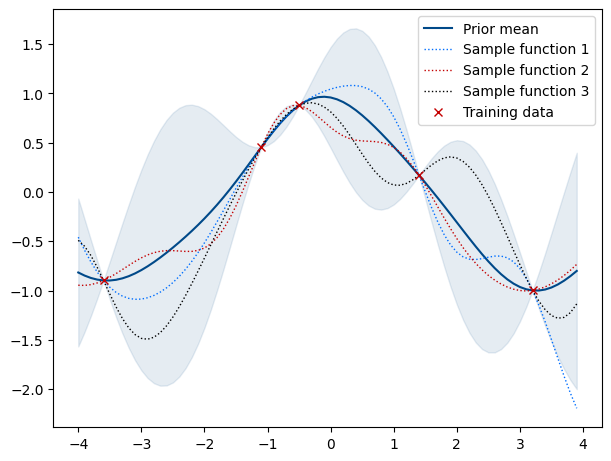

In [ ]:
# Generate noise-free training data
x_obs = np.array([[-3.6], [-1.1], [-0.5], [1.4], [3.2]])
y_obs = np.cos(x_obs)

# Compute the posterior predictive mean and covariance
mean_s, covariance_s = posterior(x, x_obs, y_obs)

# Sample from the posterior
# Plot the results
num_samples = 3
fig, axs = plt.subplots(figsize=(6, 4.5), layout="constrained")
plot_gp_result(axs, mean_s, covariance_s, x, num_samples=num_samples, x_obs=x_obs, y_obs=y_obs)

#### **Noisy training data prediction**

If some noise is included in the model, training points are only approximated and the variance at the training points is non-zero.

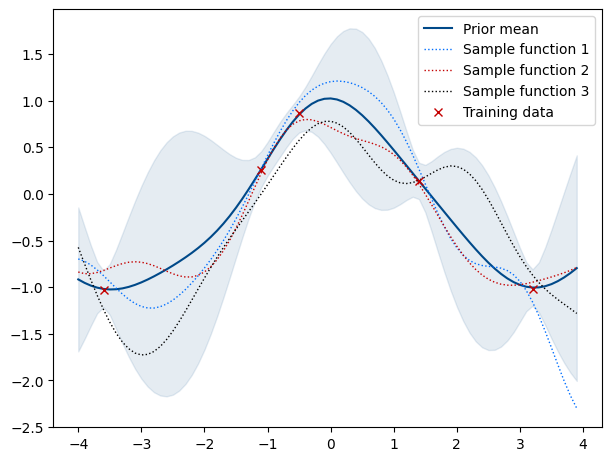

In [ ]:
# Set noise level to observe the difference
noise_std = 0.1

# Generate noisy training data
x_obs = np.array([[-3.6], [-1.1], [-0.5], [1.4], [3.2]])
y_obs = np.cos(x_obs) + noise_std * np.random.randn(*x_obs.shape)

# Compute the posterior predictive mean and covariance
mean_s, covariance_s = posterior(x, x_obs, y_obs, sigma_n=noise_std)

# Sample from the posterior
# Plot the results
num_samples = 3
fig, axs = plt.subplots(figsize=(6, 4.5), layout="constrained")
plot_gp_result(axs, mean_s, covariance_s, x, num_samples=num_samples, x_obs=x_obs, y_obs=y_obs)

#### **Impact of covariance and noise parameters**

The following example demonstrates how the covariance parameters $l$ (length scale) and $\sigma_f$ (signal variance), along with the noise parameter $\sigma_n$, influence the behaviour of the Gaussian process.

- **Length Scale $l$**: A higher $l$ value results in smoother functions, leading to coarser approximations of the training data. In contrast, smaller $l$ values produce functions with greater variability, creating more fluctuation and wider confidence intervals between the training points.
  
- **Signal Variance $\sigma_f$**: This parameter controls the magnitude of the vertical variation of the GP functions. Larger $\sigma_f$ values lead to wider confidence intervals, especially noticeable outside the training data range, as seen in the second-row right figure.

- **Noise Parameter $\sigma_n$**: Representing the noise in the training data, larger $\sigma_n$ values promote a more generalized, coarser approximation, helping to avoid overfitting, especially in the presence of noisy data.

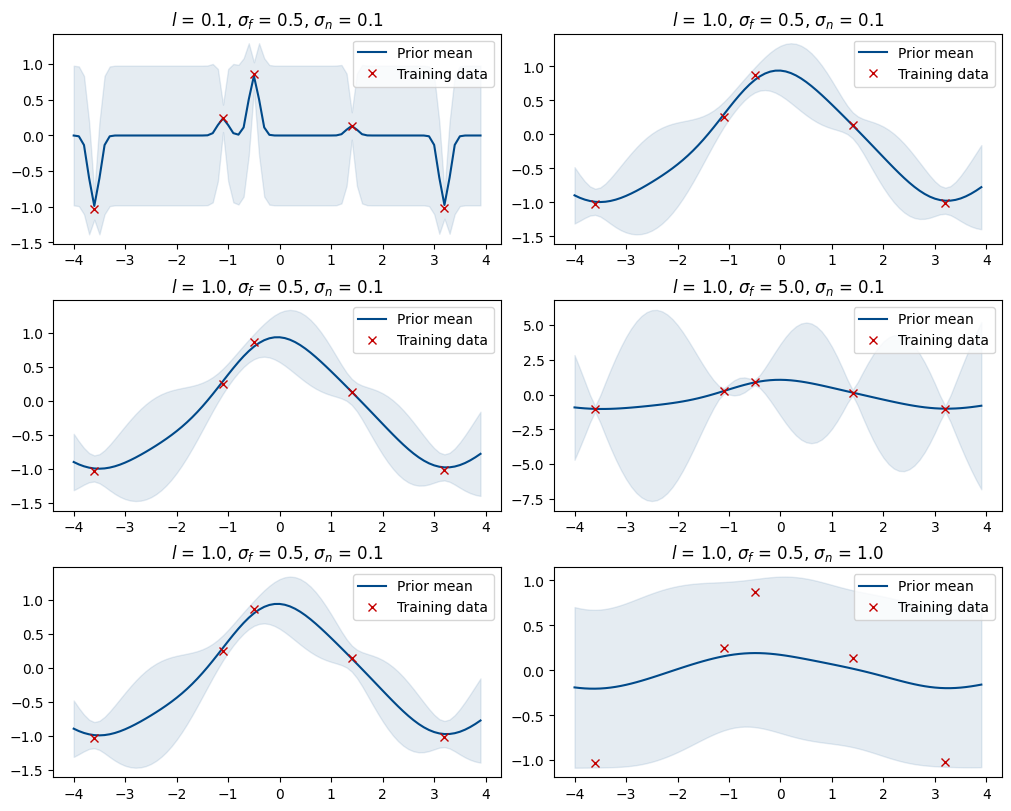

In [ ]:
# Define a matrix of hyperparameters
# with the first row representing the length scale, the second row the signal variance, and the third row the noise parameter
hyperparams = [
    (0.1, 0.5, 0.1),
    (1.0, 0.5, 0.1),
    (1.0, 0.5, 0.1),
    (1.0, 5.0, 0.1),
    (1.0, 0.5, 0.1),
    (1.0, 0.5, 1.0),
]

# Plot the gp results for different parameters
fig, axs = plt.subplots(3, 2, figsize=(10, 8), layout="constrained")

for i, (l, sigma_f, sigma_n) in enumerate(hyperparams):
    ax = axs.flat[i]
    mean_s, covariance_s = posterior(x, x_obs, y_obs, l=l, sigma_f=sigma_f, sigma_n=sigma_n)
    ax.set_title(f'$l$ = {l}, $\sigma_f$ = {sigma_f}, $\sigma_n$ = {sigma_n}')
    plot_gp_result(ax, mean_s, covariance_s, x, x_obs=x_obs, y_obs=y_obs)


#### **Log marginal likelihood optimisation**

1. **Marginal likelihood**

  In Gaussian Processes, we model the joint distribution of $N$ observations $\mathbf{y}$ given the inputs $\mathbf{X}$ and the GP parameters (e.g., covariance hyperparameters). The **marginal likelihood** of the training data under the GP is:

      \begin{align}
      p(\mathbf{y} | \mathbf{X}) = \int p(\mathbf{y} | \mathbf{X}, \mathbf{\theta})p(\theta)\mathrm{d}\mathbf{\theta} =  \frac{ p(\mathbf{y} | \mathbf{f}) p(\mathbf{f} | \mathbf{X})}{p(\mathbf{f} | \mathbf{X}, \mathbf{y})}\tag{13}
      \end{align}

      where $\mathbf{\theta}$ represents the hyperparameters (e.g., length scale $l$, signal variance $\sigma_f$, and noise variance $\sigma_n^2$).

  The marginal likelihood integrates over all possible functions consistent with the GP prior and describes how likely the data is under a particular set of hyperparameters.

2. **Log marginal likelihood**

      The marginal likelihood is typically computed in log-space for numerical stability. The **log marginal likelihood** can be written as:

      \begin{align}
      \log p(\mathbf{y} \lvert \mathbf{X}) =
      \log \mathcal{N}(\mathbf{y} \lvert \boldsymbol{0},\mathbf{C}_y) =
      -\frac{1}{2} \mathbf{y}^T \mathbf{C}_y^{-1} \mathbf{y}
      -\frac{1}{2} \log \begin{vmatrix}\mathbf{C}_y\end{vmatrix}
      -\frac{n}{2} \log(2\pi) \tag{14}
      \end{align}

      Optimal values for these parameters can be estimated by maximising the log marginal likelihood. In the following we will minimise the negative log marginal likelihood with respect to parameters $l$ and $\sigma_f$, while setting $\sigma_n$ to the known noise level of the data. If the noise level is unknown, $\sigma_n$ can be estimated as well along with the other parameters.

In [ ]:
# Define a function to compute the negative log marginal likelihood
def negative_log_likelihood(x_obs, y_obs, noise_std):
    """
    Returns the negative log marginal likelihood given the training data and noise level.

    Args:
        x_obs: Training input (n, d).
        y_obs: Training output (n, 1).
        noise_std: Known noise level of the data.

    Returns:
        A function (to be optimised) to compute the negative log marginal likelihood with hyperparameters as arguments.
    """

    def neg_log_likelihood_opt(theta):
        # Covariance matrix
        C_y = sq_exp_covariance(x_obs, x_obs, l=theta[0], sigma_f=theta[1]) + noise_std**2 * np.eye(len(x_obs))

        # Cholesky decomposition
        L = np.linalg.cholesky(C_y)

        # Compute negative log marginal likelihood
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_obs))
        log_likelihood = np.sum(np.log(np.diag(L))) + 0.5 * y_obs.T.dot(alpha) + 0.5 * len(x_obs) * np.log(2 * np.pi)

        return log_likelihood

    return neg_log_likelihood_opt

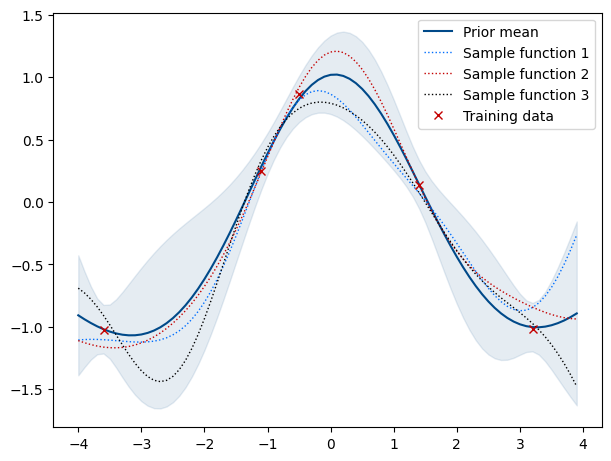

In [ ]:
# Minimise the negative log marginal likelihood with respect to l and sigma_f
result = minimize(negative_log_likelihood(x_obs, y_obs, noise_std),
                  [2.0, 1.0],
                  method='L-BFGS-B',
                  bounds=((1e-5, None), (1e-5, None)),
                  )

# Extract optimised parameters
l_opt, sigma_f_opt = result.x

# Compute the posterior predictive with the optimised kernel parameters
mean_s, covariance_s = posterior(x, x_obs, y_obs, l=l_opt, sigma_f=sigma_f_opt, sigma_n=noise_std)

# Plot the GP result
num_samples = 3
fig, axs = plt.subplots(figsize=(6, 4.5), layout="constrained")
plot_gp_result(axs, mean_s, covariance_s, x, num_samples=num_samples, x_obs=x_obs, y_obs=y_obs)
